Connected to Python 3.12.3

In [1]:
import os
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import load_model

In [2]:
train_dir = 'dataset_fruits/Training'
test_dir = 'dataset_fruits/Test'

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    batch_size=32,
    image_size=(100, 100),
    seed=123,
    shuffle=True,
)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    batch_size=32,
    image_size=(100, 100),
    seed=42,
)

Found 67692 files belonging to 131 classes.
Using 13538 files for validation.


In [5]:
class_names = sorted(os.listdir(train_dir))

In [6]:
print("Class Names:", class_names)
num_classes = len(class_names)
print("Number of Classes:", num_classes)

Class Names: ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambola', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Mar

In [7]:
def show_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Take one batch from the dataset
        for i in range(25):  # Display 25 images
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

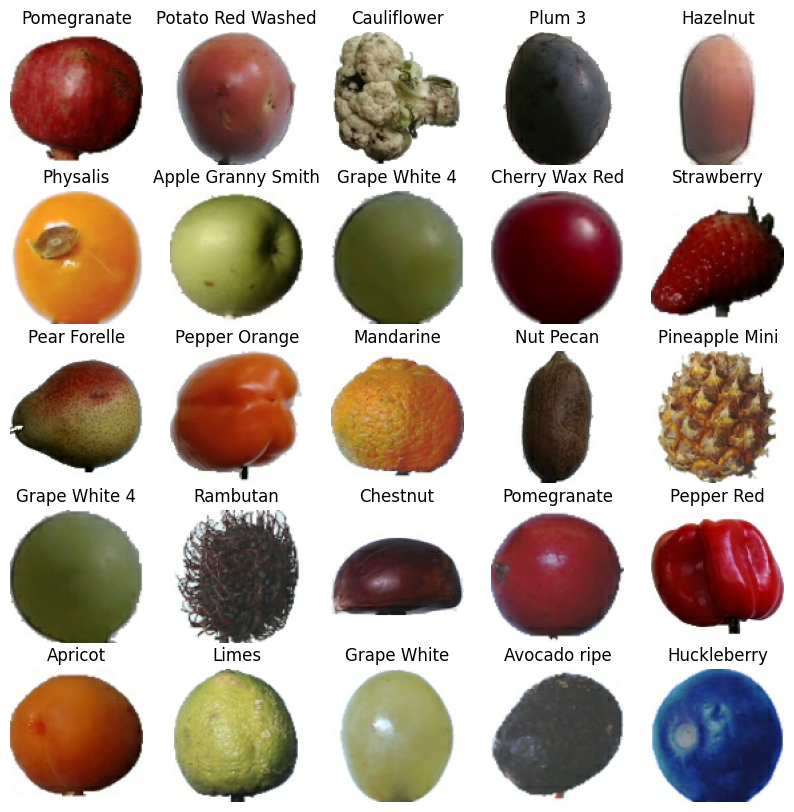

In [8]:
show_images(train_ds, class_names)
plt.show()

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

In [11]:
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(100, 100, 3))

preprocess_input = tf.keras.applications.resnet.preprocess_input
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [12]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 106, 106,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 50, 50,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 50, 50,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 52, 52,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 25, 25,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 25, 25,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 25, 25,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 25, 25,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
early_stopping = callbacks.EarlyStopping(patience=3)

In [14]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the training process
)

Epoch 1/10
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 603s 351ms/step - accuracy: 0.4656 - loss: 2.5911 - val_accuracy: 0.9690 - val_loss: 0.2760
Epoch 2/10
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 619s 366ms/step - accuracy: 0.9506 - loss: 0.2660 - val_accuracy: 0.9889 - val_loss: 0.1122
Epoch 3/10
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 579s 342ms/step - accuracy: 0.9803 - loss: 0.1206 - val_accuracy: 0.9956 - val_loss: 0.0615
Epoch 4/10
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 613s 362ms/step - accuracy: 0.9893 - loss: 0.0709 - val_accuracy: 0.9966 - val_loss: 0.0393
Epoch 5/10
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 592s 350ms/step - accuracy: 0.9932 - loss: 0.0457 - val_accuracy: 0.9987 - val_loss: 0.0263
Epoch 6/10
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 524s 310ms/step - accuracy: 0.9955 - loss: 0.0321 - val_accuracy: 0.9985 - val_loss: 0.0208
Epoch 7/10
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 904s 534ms/step - accuracy: 0.9965 - loss: 0.0248 - val_accuracy: 0.9992 - val_loss: 0.0155
Epoch 8/10
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 613s 362ms/step - ac

In [15]:
test_dir = 'dataset_fruits/Test'
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size=32,
    image_size=(100, 100),
)

test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Found 22688 files belonging to 131 classes.
709/709 ━━━━━━━━━━━━━━━━━━━━ 201s 283ms/step - accuracy: 0.9829 - loss: 0.0685
Test Loss: 0.07557079195976257
Test Accuracy: 0.9824135899543762


In [17]:
model_path = 'model/model_train.keras'

try:
    model.save(model_path)
    print(f"Model saved successfully at {model_path}")
except Exception as e:
    print(f"Error saving model: {e}")

Model saved successfully at model/model_train.keras


In [19]:
model_path = r'C:\Users\Frans\OneDrive\Desktop\WFruits\model\model_train.keras'

try:
    # Load the saved model using tf.keras
    loaded_model = load_model(model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

Error loading model: File not found: filepath=C:\Users\Frans\OneDrive\Desktop\WFruits\model\model_train.keras. Please ensure the file is an accessible `.keras` zip file.


In [20]:
model_path = r'C:\Users\Frans\OneDrive\Desktop\WFruits\backend\model\model_train.keras'

try:
    # Load the saved model using tf.keras
    loaded_model = load_model(model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

Model loaded successfully.
